#### Initialization

In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

import os
import cv2
import numpy as np
import pandas as pd

from PIL import Image
from pickle import dump
from imutils import paths
from matplotlib import pyplot as plt

from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import __version__
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import (
    Input, BatchNormalization, Conv2D, Conv2DTranspose, add, Dropout, GlobalAveragePooling2D, Dense
)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.losses import CategoricalCrossentropy, MeanAbsoluteError, MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [73]:
!nvidia-smi

/bin/bash: switchml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `switchml'
/bin/bash: _moduleraw: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `_moduleraw'
Mon Aug 30 06:44:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.142.00   Driver Version: 450.142.00   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla M60           On   | 00000000:00:1D.0 Off |                    0 |
| N/A   39C    P0    40W / 150W |   2558MiB /  7618MiB |      0%    

#### Set Variables

In [76]:
print('Thanks to almighty! (Backend tf {})\n'.format(__version__))

# OS variables
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
seed = np.random.randint(0, 115)

# Data path
path = '.'
print('Data from path {} :: Contains {}\n'.format(path, sorted(os.listdir(path))))


# utils path
model_pretrained_path = None
model_save_path = 'smc_tomato_v1.h5'
class_names_save_path = 'smc_carrot_v1_class_names.pkl'
print('Model of interest: {}'.format(model_save_path))

Thanks to almighty! (Backend tf 2.4.2)

Data from path . :: Contains ['.ipynb_checkpoints', 'early_nante_priliminary_smc', 'early_nante_priliminary_smc.zip', 'kuroda_primary_smc', 'kuroda_primary_smc.zip', 'smc_carrot_test.jpg', 'smc_carrot_test_df.csv', 'smc_carrot_v1_class_names.pkl', 'smc_carrot_val.jpg', 'smc_carrot_val_df.csv', 'smc_tomato-Copy1.ipynb']

Model of interest: smc_tomato_v1.h5


#### Load to DataFrame

In [84]:
img_paths = []
class_labels = []
classes = []
IGNORE = []

for img_path in paths.list_images(path):
    clas = img_path.split('/')[-2]
#     classes.append(img_path.split('/')[-3])
#     print(clas)
    if clas == 'good':
        class_label = 'good'
    elif clas == 'cut' or clas == 'connected':
        class_label = 'bad'
        
    class_labels.append(class_label)
    img_paths.append(img_path)

#### Select a subset for analysis

In [85]:
print('Total samples: {}'.format(len(img_paths)))

Total samples: 4418


In [9]:
len(os.listdir('early_nante_priliminary_smc/connected/'))

509

#### DataFrame and minimum requirements check

In [86]:
data = pd.DataFrame()
data['img_path'] = img_paths
data['class_label'] = class_labels
data = data.sample(frac=1., random_state=seed)

In [87]:
data['class_label'].value_counts()

good    2384
bad     2034
Name: class_label, dtype: int64

In [88]:
def df_reduce(df, col, keep_percent=150):
    min_req = min(df[col].value_counts())
    max_req = int(keep_percent/100 * min(df[col].value_counts()))

    for class_ in df[col].unique():
        print('[current count] | -> {}: {}'.format(class_, len(df[df[col] == class_])))
        if len(df[df[col] == class_]) < min_req:
            df = df[df[col] != class_]
            print('\t-> [count too low] | Discarded entire class')
            
        elif len(df[df[col] == class_]) > max_req:
            tmp_df = df[df[col] == class_][:max_req]
            df = df[df[col] != class_]
            df = df.append(tmp_df)
            print('\t-> [count too high] | reduced to --> {}'
                  .format(len(df[df[col] == class_])))
    print('* df reduce completed..\n')
    return df.sample(frac=1., random_state=seed)

In [89]:
data = df_reduce(data, 'class_label', 125)

[current count] | -> good: 2384
[current count] | -> bad: 2034
* df reduce completed..



In [90]:
data['class_label'].value_counts()

good    2384
bad     2034
Name: class_label, dtype: int64

#### Data Partitioning & Data Flow

In [91]:
#frac, split = 0.25, 0.85
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(data, test_size = 0.2, random_state = 1, stratify = data['class_label'])

val_df, test_df = train_test_split(valid_df, test_size = 0.5, random_state = 1, stratify = valid_df['class_label'])

train_df.tail()

,img_path,class_label
1870,./kuroda_primary_smc/good/img_1629796189210.jp...,good
1395,./kuroda_primary_smc/good/img_1629796534137.jp...,good
2654,./early_nante_priliminary_smc/connected/img_16...,bad
1797,./kuroda_primary_smc/good/img_1629796535156.jp...,good
889,./kuroda_primary_smc/cut/img_1629800435780.jpg...,bad


In [92]:
len(valid_df)

884

In [112]:
def show(objs,
         titles=None,
         structure='LR',
         figsize=(5, 5),
         clims=False,
         axes=False,
         xlabels=False,
         title_colors=False):
    '''
    utility function to show plots (subplots)
    '''
    plt.style.use('default')
    plt.figure(figsize=figsize)
    for i, obj in enumerate(objs):
        if structure == 'LR': plt.subplot(1, len(objs), i+1)
        elif structure == 'TB': plt.subplot(len(objs), 1, i+1)
        plt.imshow(obj)
        #
        if axes: plt.axis(axes[i])
        else: plt.axis('off')
        #
        if xlabels: plt.xlabel(xlabels[i])
        #
        if clims: plt.clim(clims[i])
        #
        if titles:
            plt.title(titles[i], color=title_colors[i] if title_colors else 'teal')
    plt.show()

In [113]:
def prep_func(img):
    '''
    prep function
    '''
    img_hsv = cv2.cvtColor(np.uint8(img), cv2.COLOR_RGB2HSV)
    
    mask = cv2.inRange(img_hsv, np.uint8([5, 115, 115]), np.uint8([25, 255, 255]))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))
    img[mask < 0.11] = 255
    return img / 255.0

In [114]:
def custom_generator(
    df,
    image_dim=(448, 224),
    decode_dim=(399, 175),
    batch_size=24
):
    '''
    Datagen from Dataframe
     * coloums must contain: img_path & mask_path
    
    Yeilds:
        batch of images, batch of masks
    '''
    
    datagen_image = image.ImageDataGenerator(
        rescale=1./255
    )
    generator_image = datagen_image.flow_from_dataframe(
        df,
        x_col='img_path',
        target_size=image_dim,
        color_mode='rgb',
        class_mode=None,
        batch_size=batch_size,
        seed=seed
    )
    
    datagen_op = image.ImageDataGenerator(
        rescale=1./255#preprocessing_function=prep_func
    )
    generator_op = datagen_op.flow_from_dataframe(
        df,
        x_col='img_path',
        y_col='class_label',
        target_size=decode_dim,
        color_mode='rgb',
#         class_mode = 'binary',
        batch_size=batch_size,
        seed=seed
    )
    
    while True:
        yield generator_image.next(), generator_op.next()

Found 2500 validated image filenames.
Found 2500 validated image filenames belonging to 2 classes.


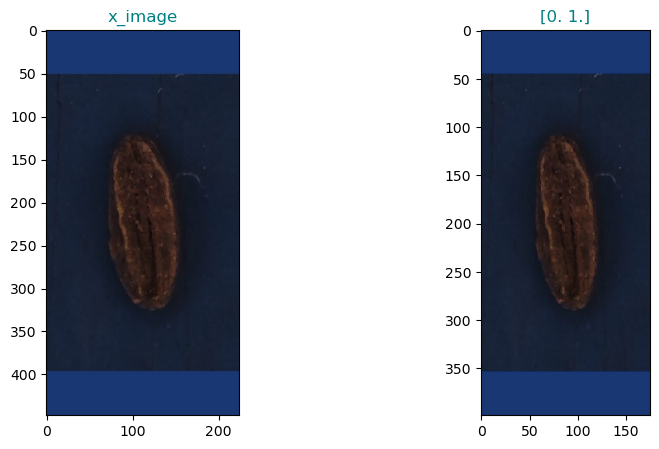

In [115]:
def check_generator(generator, suptitle):
    '''
    Check the generator
    '''
    batch_of_images, [batch_for_decoder, batch_of_labels] =  next(generator)
    x = batch_for_decoder[0]
    
    x_image, y_image, title = [
        np.squeeze(batch_of_images[0]),
        np.squeeze(batch_for_decoder[0]),
        batch_of_labels[0]
    ]
    show(
        [x_image, y_image],
        ['x_image', title],
        clims=[[0, 1], [0, 1]],
        axes=['image', 'image'],
        figsize=((10, 5))
    )

check_generator(custom_generator(train_df[:2500], batch_size=2), 'Check Generator')

In [116]:
batch_size = 32

train_generator = custom_generator(train_df, batch_size=batch_size)
steps_per_epoch = len(train_df) // batch_size

val_generator = custom_generator(val_df, batch_size=batch_size)
val_steps = len(val_df) // batch_size

Found 3534 validated image filenames.
Found 3534 validated image filenames belonging to 2 classes.


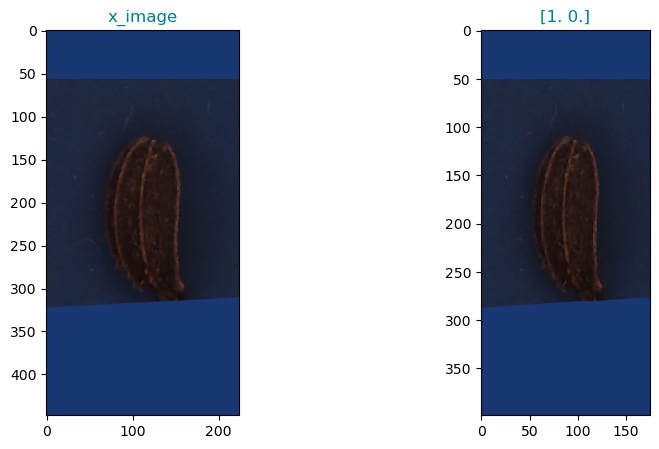

In [117]:
check_generator(train_generator, 'train_generator')

#### Class Map (utils)

In [118]:
class_names = sorted(set(data['class_label']))
NUM_CLASSES = len(class_names)
dump({'class_names' : class_names}, open(class_names_save_path, 'wb'))
print('* Classes:', class_names)

* Classes: ['bad', 'good']


#### <font color='Teal'>Model Architecture</font> & Training

In [119]:
def build_model(NUM_CLASSES, input_shape=(84, 84, 3), summary=True):
    '''
    Later
    '''
    
    input_layer = Input(shape=input_shape, name='input_layer')
    
    # ---------------------------------------------------------------------------------------------------
    # Encoder
    BN = BatchNormalization(name='Normalize')(input_layer)
    E0 = Conv2D(14, (3, 3), activation='relu')(BN)
    E1 = Conv2D(28, (3, 3), strides=(2, 2), padding='valid', activation='relu', kernel_initializer="he_uniform", name='E1')(E0)
    E2 = Conv2D(56, (3, 3), strides=(2, 2), padding='valid', activation='relu', kernel_initializer="he_uniform", name='E2')(E1)
    E2_bn = BatchNormalization(name='E2_Normalize')(E2)
    E2_d = Dropout(0.15, name = "E2_Droput")(E2_bn)
    E3 = Conv2D(56, (3, 3), strides=(2, 2), padding='valid', activation='relu', kernel_initializer="he_uniform", name='E3')(E2_d)
    E4 = Conv2D(96, (3, 3), strides=(2, 2), padding='valid', activation='relu', kernel_initializer="he_uniform", name='E4')(E3)
    E4_bn = BatchNormalization(name='E4_Normalize')(E4)
    E4_d = Dropout(0.15, name = "E4_Droput")(E4_bn)
    E5 = Conv2D(128, (3, 3), strides=(1, 1), padding='valid', activation='relu', kernel_initializer="he_uniform", name='E5')(E4_d)
    
    # ---------------------------------------------------------------------------------------------------
    # Decoder
    D7 = Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer="he_uniform", name='D7')(E5)
    D6 = add([D7, E5], name='D7_add')
    D5 = Conv2DTranspose(96, (3, 3), padding='valid', strides=(2, 2), activation='relu', kernel_initializer="he_uniform", name='D6')(D6)
    D4 = Conv2DTranspose(56, (3, 3), padding='valid', strides=(2, 2), activation='relu', kernel_initializer="he_uniform", name='D5')(D5)
    D3 = Conv2DTranspose(28, (3, 3), padding='valid', strides=(2, 2), activation='relu', kernel_initializer="he_uniform", name='D4')(D4)
    D2 = Conv2DTranspose(14, (3, 3), padding='valid', strides=(2, 2), activation='relu', kernel_initializer="he_uniform", name='D3')(D3)
    D0 = Conv2D(3, (1, 1), padding='same', activation='tanh', name='decoder_o/p')(D2)
    
    # ---------------------------------------------------------------------------------------------------
    # Classifier
    C7 = Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer="he_uniform", name='C7')(E5)
    C6 = add([C7, E5], name='C7_add')
    C5 = BatchNormalization(name='C6')(C6)
    C4 = Conv2D(64, (3, 3), padding='valid', strides=(1, 1), activation='relu', kernel_initializer="he_uniform", name='C5')(C5)
    C3 = GlobalAveragePooling2D(name='C3')(C4)
    C2 = Dense(16, activation='relu', kernel_initializer="he_uniform", name='C2')(C3)
    C1 = Dropout(0.2, name='C1')(C2) 
    C0 = Dense(NUM_CLASSES, activation='softmax', name='classifier_o/p')(C1)
    # Build Model
    model = Model(input_layer, [D0, C0], name='seed_vision')
    
    print('* Model successfully built.. with {} parameters'.format(model.count_params()))
    if summary: model.summary()
    return model


def compile_model(model):
    '''
    Compile the Model
    '''
    # Compile Model
    model.compile(
        optimizer=Adam(0.001),
        loss={
            'decoder_o/p': MeanSquaredError(),
            'classifier_o/p': CategoricalCrossentropy(label_smoothing = 0.2)#BinaryCrossentropy()  
        },
        loss_weights={
            'decoder_o/p': 15.,
            'classifier_o/p': 2.
        },
        metrics={
            'classifier_o/p': ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
             },
    )
    print('* Model successfully compiled..')
    return model

#### Train the model

In [120]:
%%time

# Build Model
model = build_model(NUM_CLASSES, input_shape=(448, 224, 3))

# OR Load Model of Interest
# model = load_model('smc_tomato_v1_smaller_imbalance_without_other.h5')

model = compile_model(model)

* Model successfully built.. with 753617 parameters
Model: "seed_vision"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 448, 224, 3) 0                                            
__________________________________________________________________________________________________
Normalize (BatchNormalization)  (None, 448, 224, 3)  12          input_layer[0][0]                
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 446, 222, 14) 392         Normalize[0][0]                  
__________________________________________________________________________________________________
E1 (Conv2D)                     (None, 222, 110, 28) 3556        conv2d_3[0][0]                   
____________________________________

In [121]:
%%time

num_epochs = 30
patience = min(max(5, num_epochs//5), 10)

early_stopping = EarlyStopping(
            monitor='val_classifier_o/p_accuracy',
            min_delta=0,
            patience=patience,
            verbose=1,
            mode='auto',
            restore_best_weights=True
        )

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=val_steps,
    epochs=num_epochs,
    callbacks=[early_stopping]  
)

# model.save(model_save_path)

Epoch 1/30
110/110 [==============================] - ETA: 0s - loss: 1.4498 - decoder_o/p_loss: 0.0273 - classifier_o/p_loss: 0.5205 - classifier_o/p_accuracy: 0.8380 - classifier_o/p_precision_3: 0.8380 - classifier_o/p_recall_3: 0.8380Found 442 validated image filenames.
Found 442 validated image filenames belonging to 2 classes.
110/110 [==============================] - 29s 246ms/step - loss: 1.4467 - decoder_o/p_loss: 0.0271 - classifier_o/p_loss: 0.5200 - classifier_o/p_accuracy: 0.8385 - classifier_o/p_precision_3: 0.8385 - classifier_o/p_recall_3: 0.8385 - val_loss: 3.5680 - val_decoder_o/p_loss: 0.0060 - val_classifier_o/p_loss: 1.7387 - val_classifier_o/p_accuracy: 0.5409 - val_classifier_o/p_precision_3: 0.5409 - val_classifier_o/p_recall_3: 0.5409
Epoch 2/30
110/110 [==============================] - 26s 234ms/step - loss: 0.8986 - decoder_o/p_loss: 0.0027 - classifier_o/p_loss: 0.4291 - classifier_o/p_accuracy: 0.9364 - classifier_o/p_precision_3: 0.9364 - classifier_o/p_

In [3]:
model = load_model('smc_carrot_v2.h5')

Extension horovod.torch has not been built: /home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-37m-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
[2021-08-30 07:56:49.499 ip-10-16-20-21:8770 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-08-30 07:56:49.527 ip-10-16-20-21:8770 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


In [7]:
model.layers

In [10]:
new_model = Model(model.input, model.get_layer('classifier_o/p').output, name='seed_vision')

In [11]:
new_model.summary()

Model: "seed_vision"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 448, 224, 3) 0                                            
__________________________________________________________________________________________________
Normalize (BatchNormalization)  (None, 448, 224, 3)  12          input_layer[0][0]                
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 446, 222, 14) 392         Normalize[0][0]                  
__________________________________________________________________________________________________
E1 (Conv2D)                     (None, 222, 110, 28) 3556        conv2d_3[0][0]                   
________________________________________________________________________________________

In [12]:
new_model.save('smc_carrot_v2_without_decoder.h5')

#### <font color='Teal'>Performance Evaluation</font>

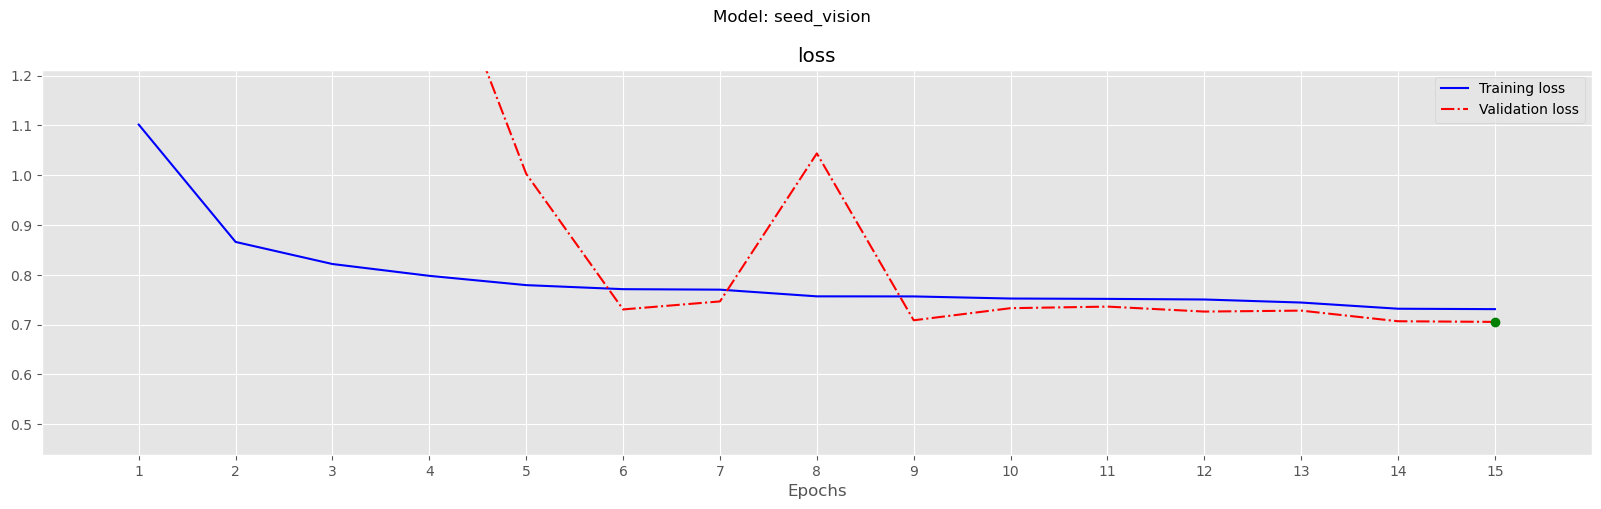

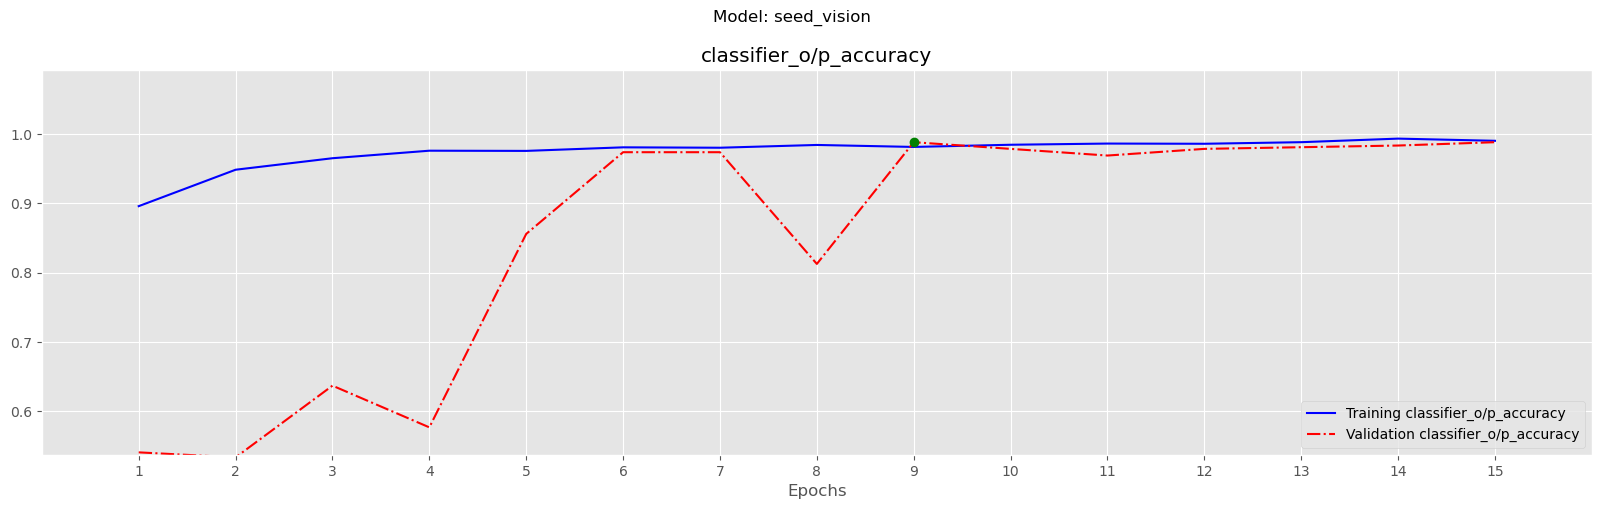

In [123]:
def learing_curves_plotter(history, key, mode):
    '''
    Plot Learning curves
    
    Required items:
        history: tensorflow.python.keras.callbacks.History object
        keys: dict object (subset of history.history.keys())
            * Validation keys automatically inherited
            
    Returns: None
         Shows matplotlib.pyplot figure
    '''
    epochs = np.array(history.epoch) + 1
    hist = history.history
    plt.figure(figsize=(20, 5))
    plt.style.use('ggplot')   
    plt.plot(epochs, hist[key], 'b', label='Training ' + key) 
    plt.plot(epochs, hist['val_' + key], '-.r', label='Validation ' + key)
    plt.xlim([0, len(hist[key]) + 1])
    plt.title(key), plt.xlabel('Epochs'), plt.xticks(epochs)
    if mode=='min':
        plt.ylim([0.6 * np.min(hist[key]), 1.1 * np.max(hist[key])])
        plt.plot(np.argmin(hist['val_' + key])+1, np.min(hist['val_' + key]), 'og')
        plt.legend(loc='upper right')
    elif mode=='max':
        plt.ylim([0.6 * np.min(hist[key]), 1.1 * np.max(hist[key])])
        plt.plot(np.argmax(hist['val_' + key])+1, np.max(hist['val_' + key]), 'og')
        plt.legend(loc='lower right')
    plt.suptitle('Model: {}'.format(history.model.name), x=0.5, y=1)
    plt.show()

learing_curves_plotter(history, 'loss', 'min')
learing_curves_plotter(history, 'classifier_o/p_accuracy', 'max')

##### Confusion Matrix and Sample Results

In [124]:
# def plot_confusion_matrix(val_df, class_names):
#     '''
#     To Plot confucion matrix (prefer validation data/generator)
#     Required:
#         test df
#         class_names
#     '''
#     global x_image_paths, x_images, y_true, y_pred_images, y_pred
#     x_image_paths = []
#     x_images = []
#     y_true = []
#     for im_path, y in zip(val_df['img_path'], val_df['class_label']):
#         img = image.load_img(im_path, color_mode='rgb', target_size=(224, 224, 3))
#         img = image.img_to_array(img).astype('float32') / 255.0
#         x_image_paths.append(im_path)
#         x_images.append(img)
#         y_true.append(class_names.index(y))
#     #
#     y_pred_images, y_pred_classes = model.predict(np.array(x_images))
#     y_pred = np.argmax(y_pred_classes, axis=-1)
#     y_pred_images[y_pred_images < 0] = 0
                                              
#     plt.style.use('default')
#     cm = confusion_matrix(y_true, y_pred)
#     fig, ax = plt.subplots(figsize=(5, 7))
#     im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
#     ax.set(xticks=np.arange(cm.shape[1]),
#            yticks=np.arange(cm.shape[0]),
#            xticklabels=class_names,
#            yticklabels=class_names,
#            title='Confusion matrix \nAccuracy: {:0.2f} %'.format(sum(y_true == y_pred) / len(y_true) * 100),
#            ylabel='True label',
#            xlabel='Predicted label')
#     plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
#     for i in range(cm.shape[0]):
#         for j in range(cm.shape[1]):
#             ax.text(j, i, format(cm[i, j], 'd'),
#                     ha='center', va='center',
#                     color='white' if cm[i, j] > cm.max() / 2. else 'black')
#     fig.tight_layout()
#     plt.show()
    
# plot_confusion_matrix(val_df, class_names)

In [127]:
#import dataframe_image as dfi

def plot_confusion_matrix(classifier, val_df, y_col, class_names, save_path):
    '''
    To Plot confucion matrix (prefer validation data/generator)
    Required:
        test df
        class_names
    '''
    global x_images, x_images_view, y_true, y_pred_images, y_pred
    x_images = []
    y_true = []
    x_images_view = []
    y_pred_acc = []
    y_true_acc = []
    for im_path, y in zip(val_df['img_path'], val_df[y_col]):
        img = image.load_img(im_path, color_mode='rgb', target_size=(448, 224, 3))
        x_images_view.append(img)
        img = image.img_to_array(img).astype('float32') / 255.0
        x_images.append(img)
        y_true.append(class_names.index(y))
    #
    _, y_pred_classes = classifier.predict(np.array(x_images))
#     y_pred = np.round(y_pred_classes)#
    y_pred = np.argmax(y_pred_classes, axis=-1)
    # y_pred_images[y_pred_images < 0] = 0
    y_names = []
    for i, y in enumerate(y_pred):
        y_names.append(class_names[y])
        #y_pred_acc.append(int(y[0]))
#         y_true_acc.append(int())
#     print(y_pred_acc)
                                              
    plt.style.use('default')
    cm = confusion_matrix(y_true, y_pred, labels = [0,1])
    fig, ax = plt.subplots(figsize=(5, 7))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=class_names,
           yticklabels=class_names,
           title = 'Confusion Matrix',
#            title='Accuracy_{:.2f}'.format(sum(y_true == y_pred_acc) / len(y_true) * 100),
           ylabel='True label',
           xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha='center', va='center',
                    color='white' if cm[i, j] > cm.max() / 2. else 'black')
    fig.tight_layout()
    plt.savefig(save_path)
    plt.show()
    
    
    return y_names, y_pred_classes

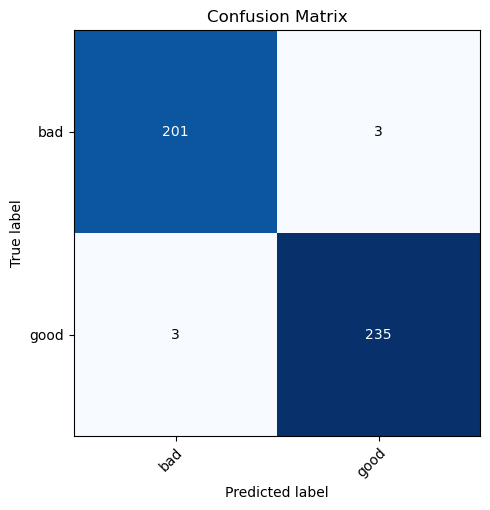

In [128]:
ypred, yscore = plot_confusion_matrix(model, val_df, 'class_label', class_names, 'smc_carrot_val_v2.jpg')
yscore = np.max(yscore, axis = 1)
val_df['tf_pred'] = ypred
val_df['tf_conf'] = yscore
val_df.to_csv('smc_carrot_val_df_v2.csv')

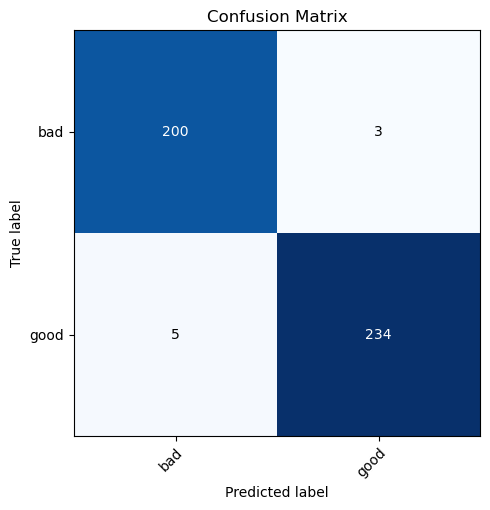

In [129]:
ypred, yscore = plot_confusion_matrix(model, test_df, 'class_label', class_names, 'smc_carrot_test_v2.jpg')
yscore = np.max(yscore, axis = 1)
test_df['tf_pred'] = ypred
test_df['tf_conf'] = yscore
test_df.to_csv('smc_carrot_test_df_v2.csv')

In [3]:
model = load_model('models/smc_carrot_v2_without_decoder.h5')

Extension horovod.torch has not been built: /home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-37m-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
[2021-08-30 14:41:43.124 ip-10-16-20-21:42807 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-08-30 14:41:43.152 ip-10-16-20-21:42807 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


In [4]:
# print(
#     'Model details\n* Name: {}'.format(model_save_path.replace('utils/', '').strip('.tf/'))
# )
print(
    'Model details\n* Name: smc_carrot'
)
print('* Input dimensions: {}'.format(model.input_shape[1:]))
print('* Number of Layers: {}'.format(len(model.layers)))
print('* Total Parameters: {:0.2f} M'.format(model.count_params() / 1e6))
# print('* Classes: {}'.format(', '.join(class_names)))
print('* Classes: bad, good')
# print('* Accuracy: {:0.2f} %'.format(sum(y_true == y_pred) / len(y_true) * 100))

Model details
* Name: smc_carrot
* Input dimensions: (448, 224, 3)
* Number of Layers: 20
* Total Parameters: 0.43 M
* Classes: bad, good


In [131]:
def show(objs,
         titles=None,
         structure='LR',
         figsize=(5, 5),
         clims=False,
         axes=False,
         xlabels=False,
         title_colors=False):
    '''
    utility function to show plots (subplots)
    '''
    plt.style.use('default')
    plt.figure(figsize=figsize)
    for i, obj in enumerate(objs):
        if structure == 'LR': plt.subplot(1, len(objs), i+1)
        elif structure == 'TB': plt.subplot(len(objs), 1, i+1)
        plt.imshow(obj)
        #
        if axes: plt.axis(axes[i])
        else:
            if not xlabels:
                plt.axis('off')
        #
        if xlabels: plt.xlabel(xlabels[i])
        #
        if clims: plt.clim(clims[i])
        #
        if titles:
            plt.title(titles[i], color=title_colors[i] if title_colors else 'teal')
    plt.show()

In [111]:
# num_samples = 24
# start = np.random.randint(0, len(x_images)-num_samples)

# val_samples = x_images[start : start + num_samples]
# val_sample_paths = x_image_paths[start : start + num_samples]
# val_predicted_images = y_pred_images[start : start + num_samples]
# val_true_classes = [class_names[y] for y in y_true][start : start + num_samples]
# val_predicted_classes = [class_names[y] for y in y_pred][start : start + num_samples]

# titles = ['{}\n({})'.format(pred, true) if true!=pred else pred
#         for (true, pred)  in zip(val_true_classes, val_predicted_classes)
#        ]

# truth_colors = ['green' if true==pred else 'red'
#         for (true, pred)  in zip(val_true_classes, val_predicted_classes)
#        ]

# xlabels = [path.split('/')[-1] for path  in val_sample_paths]

# ncols = 3
# for i in range(ncols):
#     show(
#         val_samples[i::ncols],
#         titles=titles[i::ncols],
#         figsize=(20, 5),
#         title_colors=truth_colors[i::ncols],
#     )
#     show(
#         val_predicted_images[i::ncols],
#         titles=['(decoded)']*(num_samples//ncols),
#         figsize=(20, 5),
# #         xlabels=xlabels[i::ncols]
#     )

## External Validation

In [29]:
img_paths = []
class_labels = []

IGNORE = []

for img_path in paths.list_images(path):
    clas = img_path.split('/')[-2]
#     print(clas)
    if clas == 'extval':
        class_label = 'good'
    else:
        continue
        
    class_labels.append(class_label)
    img_paths.append(img_path)

In [30]:
ext_val = pd.DataFrame()
ext_val['img_path'] = img_paths
ext_val['class_label'] = class_labels
ext_val = ext_val.sample(frac=1., random_state=seed)

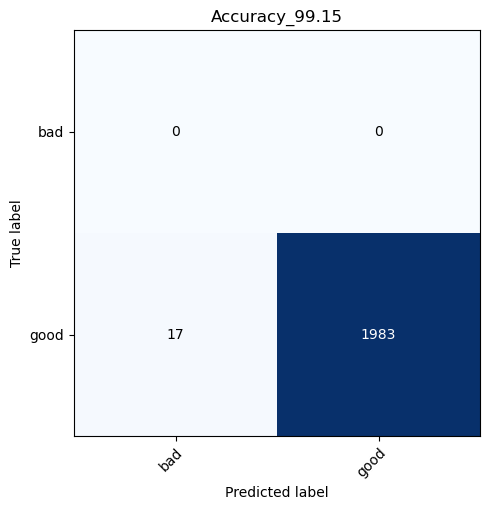

In [31]:
ypred, yscore = plot_confusion_matrix(model, ext_val, 'class_label', class_names, 'smc_tomato_ext_val.jpg')
yscore = np.max(yscore, axis = 1)
ext_val['tf_pred'] = ypred
ext_val['tf_conf'] = yscore
ext_val.to_csv('smc_tomato_ext_val_df.csv')

In [ ]:
# Gaurav Sethia, AI Intern

---